## Imports and Setup

In [1]:
import os
import sys
sys.path.insert(0, "../utils/")
import geoutils

import pandas as pd
import numpy as np
import geopandas as gpd

pd.set_option('mode.chained_assignment', None)
%load_ext autoreload
%autoreload 2

## Parameters

In [11]:
iso = 'LCA'
rgb_path = "../data/rasters/Tiles/ortho/"
ndsm_path = "../data/rasters/Tiles/ndsm/"

## Load Datasets

In [3]:
bldgs_file = f"../data/vectors/building_footprints_{iso}.gpkg"
bldgs = gpd.read_file(bldgs_file).reset_index(drop=True)
bldgs["roof_type"] = None
bldgs["roof_material"] = None
bldgs["roof_condition"] = None
bldgs["UID"] = bldgs.index
print(f"Dimensions: {bldgs.shape}")
if iso == 'DOM': print(bldgs.Layer.value_counts(normalize=True))
bldgs.head(3)

Dimensions: (69185, 7)


Shape_Leng  Shape_Area                                           geometry   
0   36.771591   84.327748  MULTIPOLYGON Z (((717760.366 1520511.462 0.000...  \
1   38.815779   79.310118  MULTIPOLYGON Z (((717797.038 1520510.844 0.000...   
2   20.482242   25.119200  MULTIPOLYGON Z (((717926.809 1520525.188 0.000...   

  roof_type roof_material roof_condition  UID  
0      None          None           None    0  
1      None          None           None    1  
2      None          None           None    2

In [4]:
geoboundaries_file = f"../data/vectors/geoboundaries_{iso}.geojson"
geoboundaries = gpd.read_file(geoboundaries_file)
geoboundaries = geoboundaries.to_crs(bldgs.crs)
print(f"Dimensions: {geoboundaries.shape}")
geoboundaries.head(3)

Dimensions: (10, 6)


shapeName shapeISO                  shapeID shapeGroup shapeType   
0    Vieux Fort    LC-11  63095687B59685242604906        LCA      ADM1  \
1  Anse la Raya    LC-01  63095687B23722655105738        LCA      ADM1   
2      Castries    LC-02  63095687B14165571905406        LCA      ADM1   

                                            geometry  
0  MULTIPOLYGON (((723611.518 1517919.455, 723630...  
1  MULTIPOLYGON (((716442.380 1534116.686, 716475...  
2  MULTIPOLYGON (((718016.970 1552385.114, 718025...

In [5]:
boundaries = geoboundaries[['shapeName', 'geometry']]
boundaries.columns = ['shape_name', 'geometry']
bldgs_merged = bldgs.sjoin(
    boundaries,
    how='left',
    predicate='intersects'
).drop(['index_right'], axis=1)
print(f"Dimensions: {bldgs_merged.shape}")
bldgs_merged.head(3)

Dimensions: (69264, 8)


Shape_Leng  Shape_Area                                           geometry   
0   36.771591   84.327748  MULTIPOLYGON Z (((717760.366 1520511.462 0.000...  \
1   38.815779   79.310118  MULTIPOLYGON Z (((717797.038 1520510.844 0.000...   
2   20.482242   25.119200  MULTIPOLYGON Z (((717926.809 1520525.188 0.000...   

  roof_type roof_material roof_condition  UID shape_name  
0      None          None           None    0    Laborie  
1      None          None           None    1    Laborie  
2      None          None           None    2    Laborie

## Generate Blank Dataset

In [6]:
if iso == 'DOM': columns = ['UID', 'Elevation', 'Layer', 'shape_name', 'geometry']
else: columns = ['UID','shape_name', 'geometry']
columns = columns + ['roof_type', 'roof_material', 'roof_condition']
filename = f"../data/vectors/building_footprints_annotated_{iso}.gpkg"
bldgs_ann = bldgs_merged[columns]
#bldgs_ann.to_file(filename, driver='GPKG')
bldgs_ann.head(3)

UID shape_name                                           geometry   
0    0    Laborie  MULTIPOLYGON Z (((717760.366 1520511.462 0.000...  \
1    1    Laborie  MULTIPOLYGON Z (((717797.038 1520510.844 0.000...   
2    2    Laborie  MULTIPOLYGON Z (((717926.809 1520525.188 0.000...   

  roof_type roof_material roof_condition  
0      None          None           None  
1      None          None           None  
2      None          None           None

## Inspect Data Annotations

In [12]:
columns = ['UID','shape_name', 'geometry', 'roof_type', 'roof_material', 'roof_condition']
bldgs_file = f"../data/vectors/building_footprints_annotated_{iso}.gpkg"
tiles_file = f"../data/vectors/annotation_tiles_{iso}.gpkg"
bldgs = gpd.read_file(bldgs_file)
tiles = gpd.read_file(tiles_file)

bldgs = bldgs[columns]
bldgs = bldgs[(bldgs.roof_type != 'OTHER') & (bldgs.roof_material != 'OTHER')]
bldgs.roof_type = bldgs.roof_type.replace({'PYRAMID': 'HIP', 'HALF_HIP': 'HIP'})
print(f"Dimensions: {bldgs.shape}")
bldgs_shape = bldgs[
    (~bldgs.roof_type.isna()) 
    | (~bldgs.roof_material.isna())
].shape
tiles = tiles[tiles.status == 'COMPLETE']
print(f"Number of annotated tiles {tiles.shape}")
print(f"Dimensions (non-null): {bldgs_shape}")
print(bldgs.roof_material.value_counts())
print(bldgs.roof_type.value_counts())
bldgs.head(3)

Dimensions: (69262, 6)
Number of annotated tiles (28, 7)
Dimensions (non-null): (2175, 6)
roof_material
HEALTHY_METAL      1342
IRREGULAR_METAL     507
CONCRETE_CEMENT     171
INCOMPLETE          154
Name: count, dtype: int64
roof_type
GABLE      1063
HIP         710
FLAT        274
NO_ROOF     128
Name: count, dtype: int64


UID shape_name                                           geometry   
0  0.0    Laborie  MULTIPOLYGON Z (((717760.366 1520511.462 0.000...  \
1  1.0    Laborie  MULTIPOLYGON Z (((717797.038 1520510.844 0.000...   
2  2.0    Laborie  MULTIPOLYGON Z (((717926.809 1520525.188 0.000...   

  roof_type roof_material  roof_condition  
0       NaN           NaN             NaN  
1       NaN           NaN             NaN  
2       NaN           NaN             NaN

## Generate Image Crops

In [13]:
in_file = f"../data/rasters/Ortho/ortho_{iso}.tif"
columns = ['roof_type', 'roof_material']
for column in columns:
    out_dir = os.path.join(rgb_path, column)
    geoutils.generate_image_crops(
        bldgs, 
        column=column, 
        in_file=in_file, 
        iso=iso,
        out_dir=out_dir
    )

roof_type size: (2175, 6)


FLAT: 100%|███████████████| 274/274 [00:48<00:00,  5.68it/s]                                                           


roof_material size: (2174, 6)


IRREGULAR_METAL: 100%|███████████████| 507/507 [01:31<00:00,  5.53it/s]                                                


In [14]:
in_file = f'../data/rasters/DSM/ndsm_{iso}.tif'
columns = ['roof_type', 'roof_material']
for column in columns:
    out_dir = os.path.join(ndsm_path, column)
    geoutils.generate_image_crops(
        bldgs, 
        column=column, 
        in_file=in_file, 
        out_dir=out_dir,
        iso=iso,
        clip=True
    )

roof_type size: (2175, 6)


FLAT: 100%|███████████████| 274/274 [01:08<00:00,  4.01it/s]                                                           


roof_material size: (2174, 6)


IRREGULAR_METAL: 100%|███████████████| 507/507 [02:19<00:00,  3.63it/s]                                                


## Inspect Image Crops

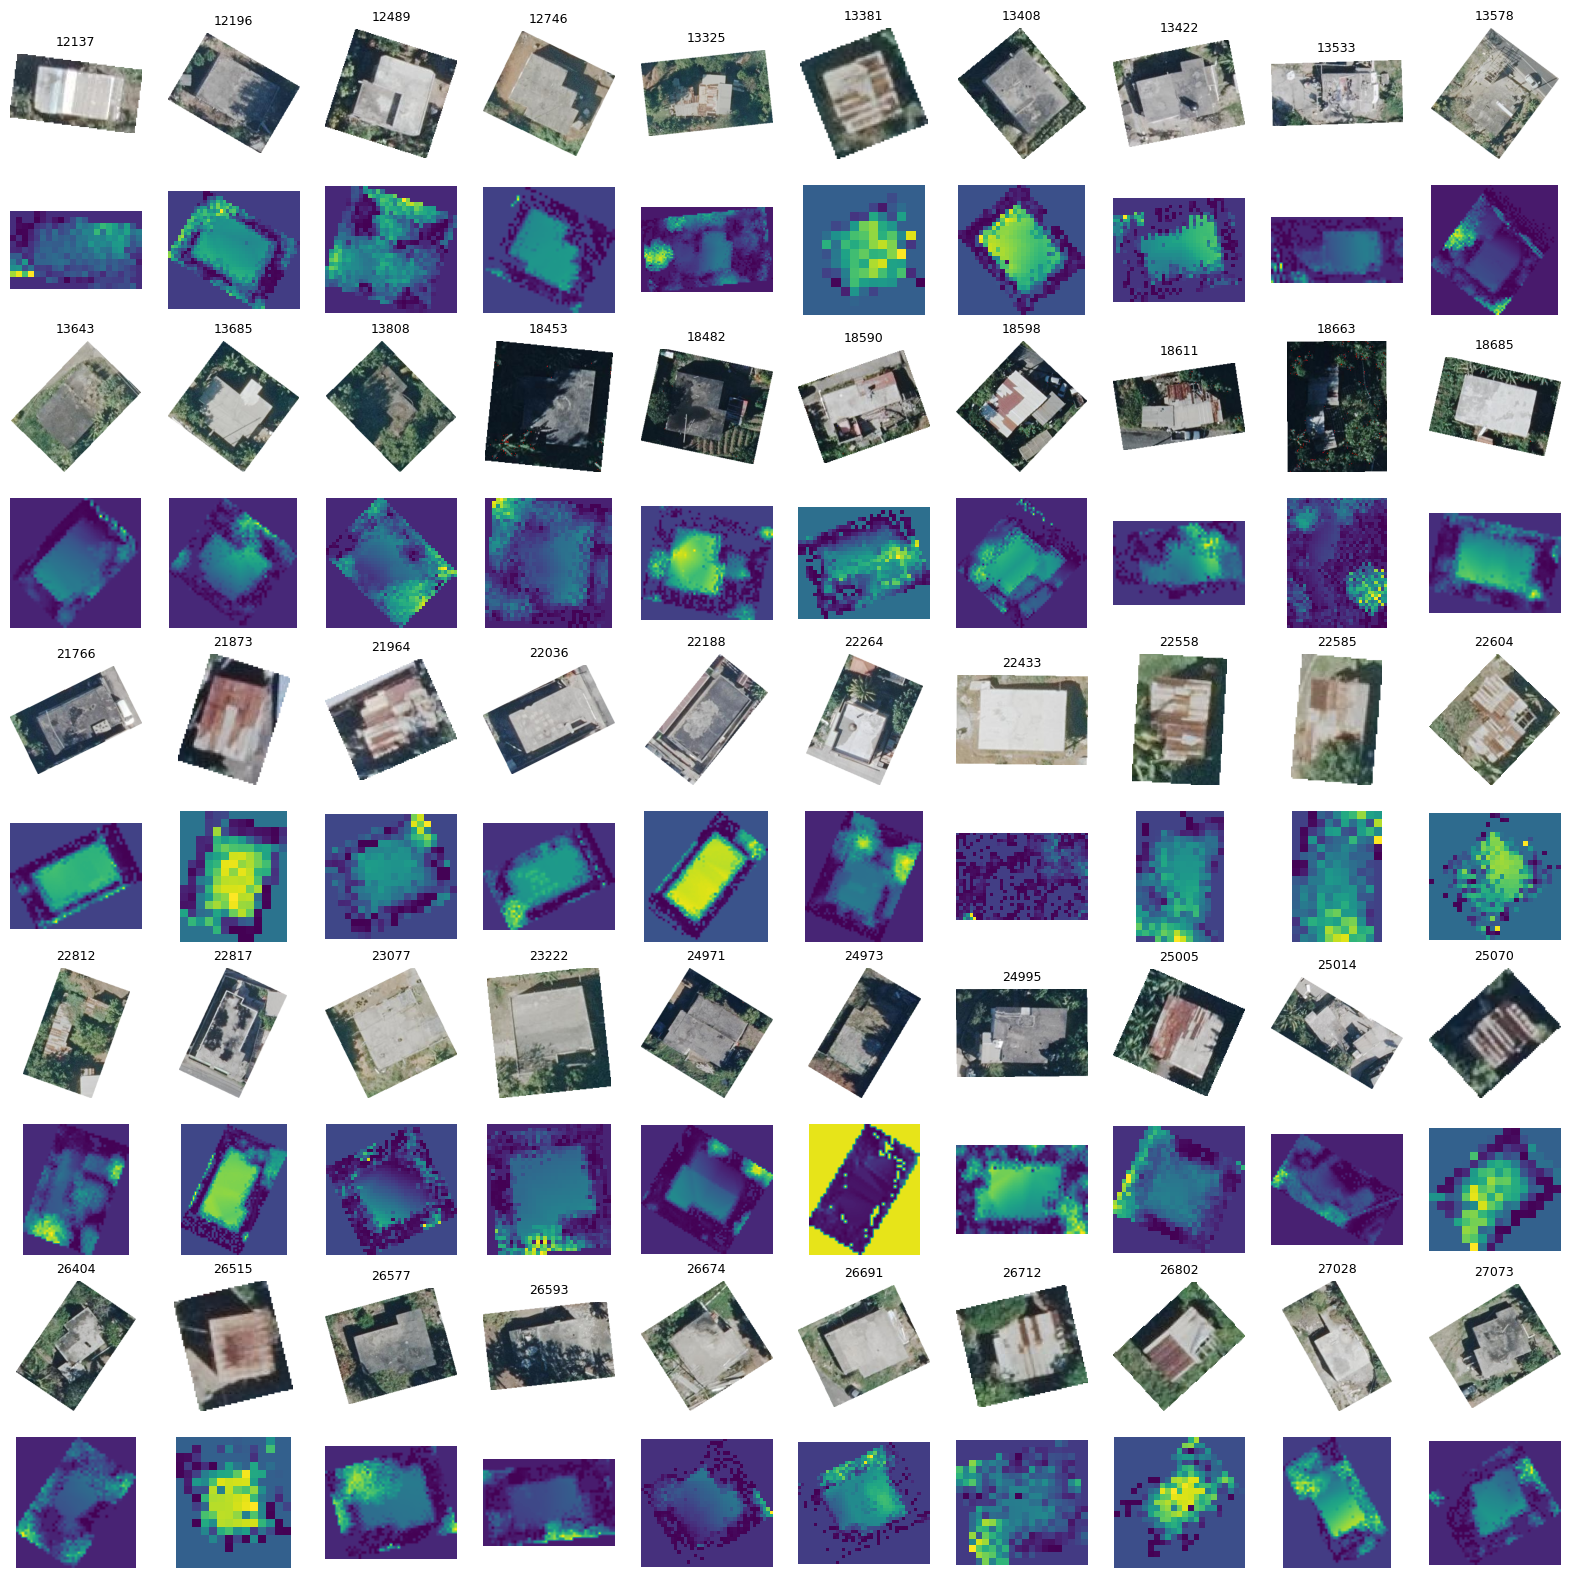

In [19]:
geoutils.inspect_image_crops(
    bldgs, 
    column='roof_type', 
    value='FLAT',
    rgb_path=rgb_path, 
    ndsm_path=ndsm_path, 
    iso=iso,
    index=50, 
    n_rows=5,
    n_cols=10,
    figsize=(20,20)
)

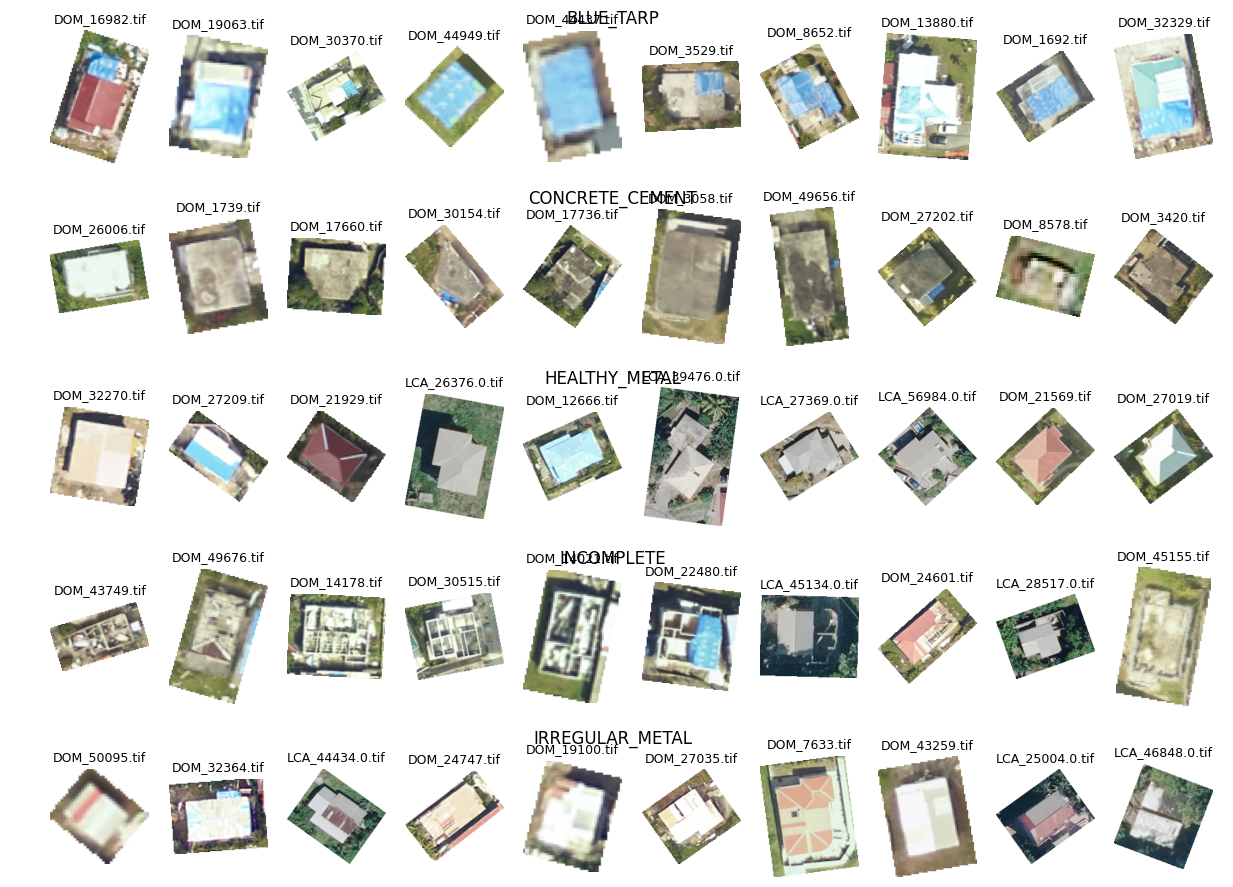

In [16]:
n_samples = 10
geoutils.visualize_image_crops(rgb_path, 'roof_material', n_samples=10, n_channels=3, figsize=(15,9))

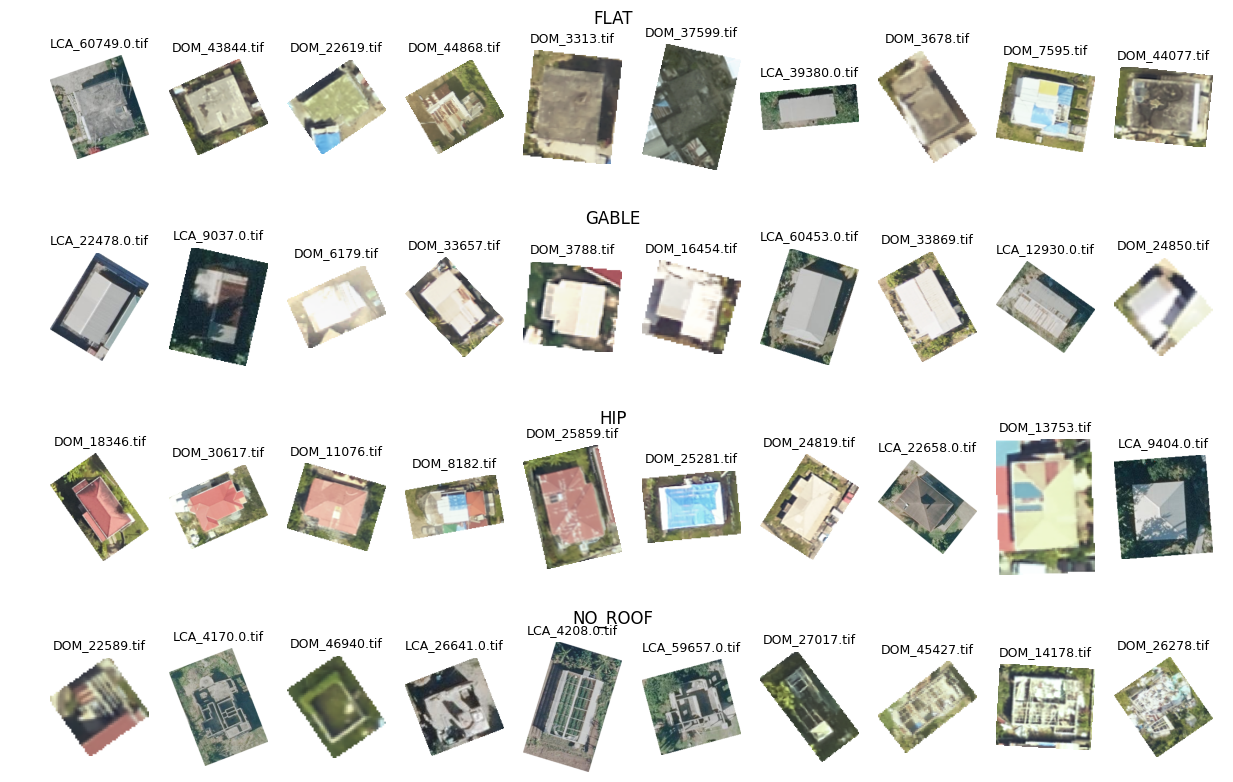

In [17]:
geoutils.visualize_image_crops(rgb_path, 'roof_type', n_samples=10, n_channels=3, figsize=(15,8))

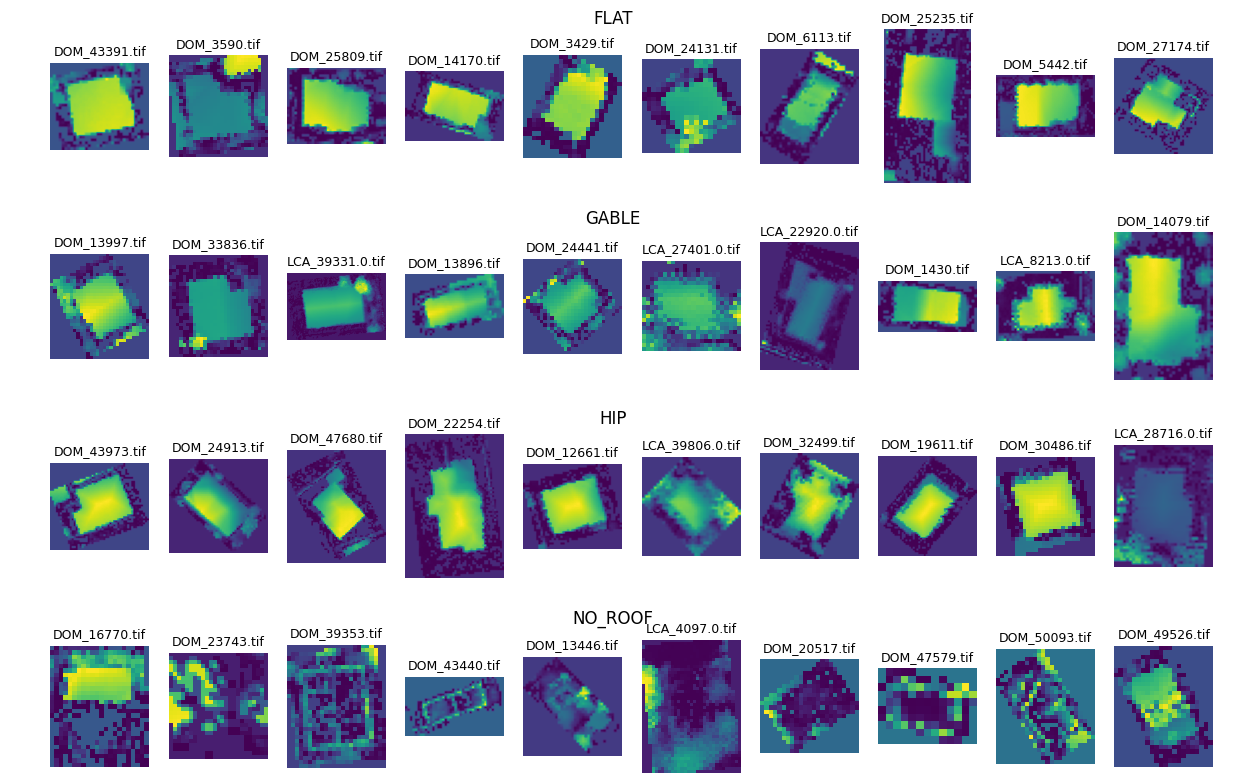

In [18]:
geoutils.visualize_image_crops(ndsm_path, 'roof_type', n_samples=10, n_channels=1, figsize=(15,8))